In [ ]:
import pandas as pd

import numpy as np

seasons = ['nov', 'jan', 'jun', 'sep']

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/all_bands_100k.csv')
for season in seasons:
    print(f"\nAdding indices for {season.upper()}...")

    # 1. EVI - Enhanced Vegetation Index
    df[f'{season}_evi'] = 2.5 * ((df[f'{season}_B08'] - df[f'{season}_B04']) /
                                 (df[f'{season}_B08'] + 6*df[f'{season}_B04'] - 7.5*df[f'{season}_B02'] + 1))

    # 2. SAVI - Soil Adjusted Vegetation Index
    L = 0.5
    df[f'{season}_savi'] = ((df[f'{season}_B08'] - df[f'{season}_B04']) /
                            (df[f'{season}_B08'] + df[f'{season}_B04'] + L)) * (1 + L)

    # 3. GNDVI - Green NDVI
    df[f'{season}_gndvi'] = (df[f'{season}_B08'] - df[f'{season}_B03']) / (df[f'{season}_B08'] + df[f'{season}_B03'] + 0.001)

    # 4. VARI - Visible Atmospherically Resistant Index
    df[f'{season}_vari'] = (df[f'{season}_B03'] - df[f'{season}_B04']) / (df[f'{season}_B03'] + df[f'{season}_B04'] - df[f'{season}_B02'] + 0.001)

    # 5. NDWI - Normalized Difference Water Index (for water stress)
    df[f'{season}_ndwi'] = (df[f'{season}_B03'] - df[f'{season}_B08']) / (df[f'{season}_B03'] + df[f'{season}_B08'] + 0.001)

    # 6. CI - Chlorophyll Index
    df[f'{season}_ci'] = (df[f'{season}_B08'] / df[f'{season}_B03']) - 1

    # 7. NDVIre - Red Edge NDVI (using B05 if available, otherwise approximate)
    # Using B04 as proxy if B05 not available
    df[f'{season}_ndvire'] = (df[f'{season}_B08'] - df[f'{season}_B04']) / (df[f'{season}_B08'] + df[f'{season}_B04'] + 0.001)

    # 8. MSAVI - Modified Soil Adjusted Vegetation Index
    df[f'{season}_msavi'] = (2 * df[f'{season}_B08'] + 1 - np.sqrt((2 * df[f'{season}_B08'] + 1)**2 - 8 * (df[f'{season}_B08'] - df[f'{season}_B04']))) / 2

    print(f"   Added 8 indices → Total {season.upper()} features: {len([c for c in df.columns if season in c])}")

print(f"\n New total columns: {len(df.columns)}")
print(f"New features: +{len(df.columns) - 20} indices")

jun_indices = [col for col in df.columns if 'jun_' in col and col not in ['jun_B02', 'jun_B03', 'jun_B04', 'jun_B08']]
print(f"\nNew JUNE indices ({len(jun_indices)}):")
print(jun_indices)

print("\n Sample statistics for new indices:")
print(df[jun_indices].describe())

enhanced_csv = '/content/drive/MyDrive/Colab Notebooks/all_bands_with_indices.csv'
df.to_csv(enhanced_csv, index=False)
print(f"\nEnhanced dataset saved to: {enhanced_csv}")


Adding indices for NOV...
   Added 8 indices → Total NOV features: 16

Adding indices for JAN...
   Added 8 indices → Total JAN features: 16

Adding indices for JUN...
   Added 8 indices → Total JUN features: 16

Adding indices for SEP...
   Added 8 indices → Total SEP features: 16

 New total columns: 64
New features: +44 indices

New JUNE indices (12):
['jun_ndvi', 'jun_ratio84', 'jun_brightness', 'jun_diff84', 'jun_evi', 'jun_savi', 'jun_gndvi', 'jun_vari', 'jun_ndwi', 'jun_ci', 'jun_ndvire', 'jun_msavi']

 Sample statistics for new indices:
           jun_ndvi   jun_ratio84  jun_brightness    jun_diff84       jun_evi  \
count  83196.000000  8.319500e+04    83195.000000  83195.000000  83196.000000   
mean       0.145444  1.876333e+02     2518.537256   1901.890558      0.299574   
std        0.139615  5.370352e+04      815.688956   7708.758336      9.785221   
min       -0.490446  3.418803e-01        0.666667      0.000000  -1519.285714   
25%        0.058143  1.123464e+00     2116.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import pandas as pd
import numpy as np


inf_cols = []
for col in df.columns:
    if np.isinf(df[col]).any():
        inf_cols.append(col)
        print(f"   {col} contains infinity")

df = df.replace([np.inf, -np.inf], np.nan)


for col in df.columns:
    max_val = df[col].max()
    if max_val > 1e6:
        print(f"   {col} max: {max_val:.2e}")


band_cols = [col for col in df.columns if '_B' in col]
for col in band_cols:
    df[col] = df[col].clip(0, 10000)

index_cols = [col for col in df.columns if any(x in col for x in ['ndvi', 'evi', 'savi', 'gndvi', 'vari', 'ndwi', 'ndvire'])]
for col in index_cols:
    df[col] = df[col].clip(-2, 2)

ratio_cols = [col for col in df.columns if 'ratio' in col or 'ci' in col or 'msavi' in col]
for col in ratio_cols:
    df[col] = df[col].clip(0, 10)

before = len(df)
df = df.dropna()
after = len(df)
print(f"Dropped {before - after} rows with NaN values")

clean_csv = '/content/drive/MyDrive/Colab Notebooks/all_bands_indices_clean.csv'
df.to_csv(clean_csv, index=False)
print(f"Cleaned data saved to: {clean_csv}")
print(f"Final shape: {df.shape}")

Loaded 83,179 clean rows with 64 features

KHARIF MODEL (cleaned data)
KHARIF features: 16
Training KHARIF model...
   ✓ Trained in 113.0s

 KHARIF Results:
   R²:  0.1771
   RMSE: 0.1476

 RABI MODEL (cleaned data)
RABI features: 16
Training RABI model...
   ✓ Trained in 106.2s

RABI Results:
   R²:  0.3400
   RMSE: 0.1323

FINAL RESULTS
Model                R² Score       
-----------------------------------
KHARIF (June→Sept)   0.1771         
RABI (Nov→Jan)       0.3400         

top 10 FEATURES - KHARIF
   feature  importance
   jun_evi    0.190968
   jun_B08    0.137499
jun_diff84    0.121576
  jun_vari    0.097172
   jun_B02    0.093143
  jun_ndwi    0.076068
   jun_B03    0.063660
   jun_B04    0.049417
    jun_ci    0.044215
 jun_gndvi    0.041072

TOP 10 FEATURES - RABI
       feature  importance
    nov_diff84    0.265701
       nov_evi    0.101201
       nov_B04    0.076790
      nov_ndwi    0.076323
       nov_B08    0.068001
      nov_vari    0.067224
nov_brightness    0.

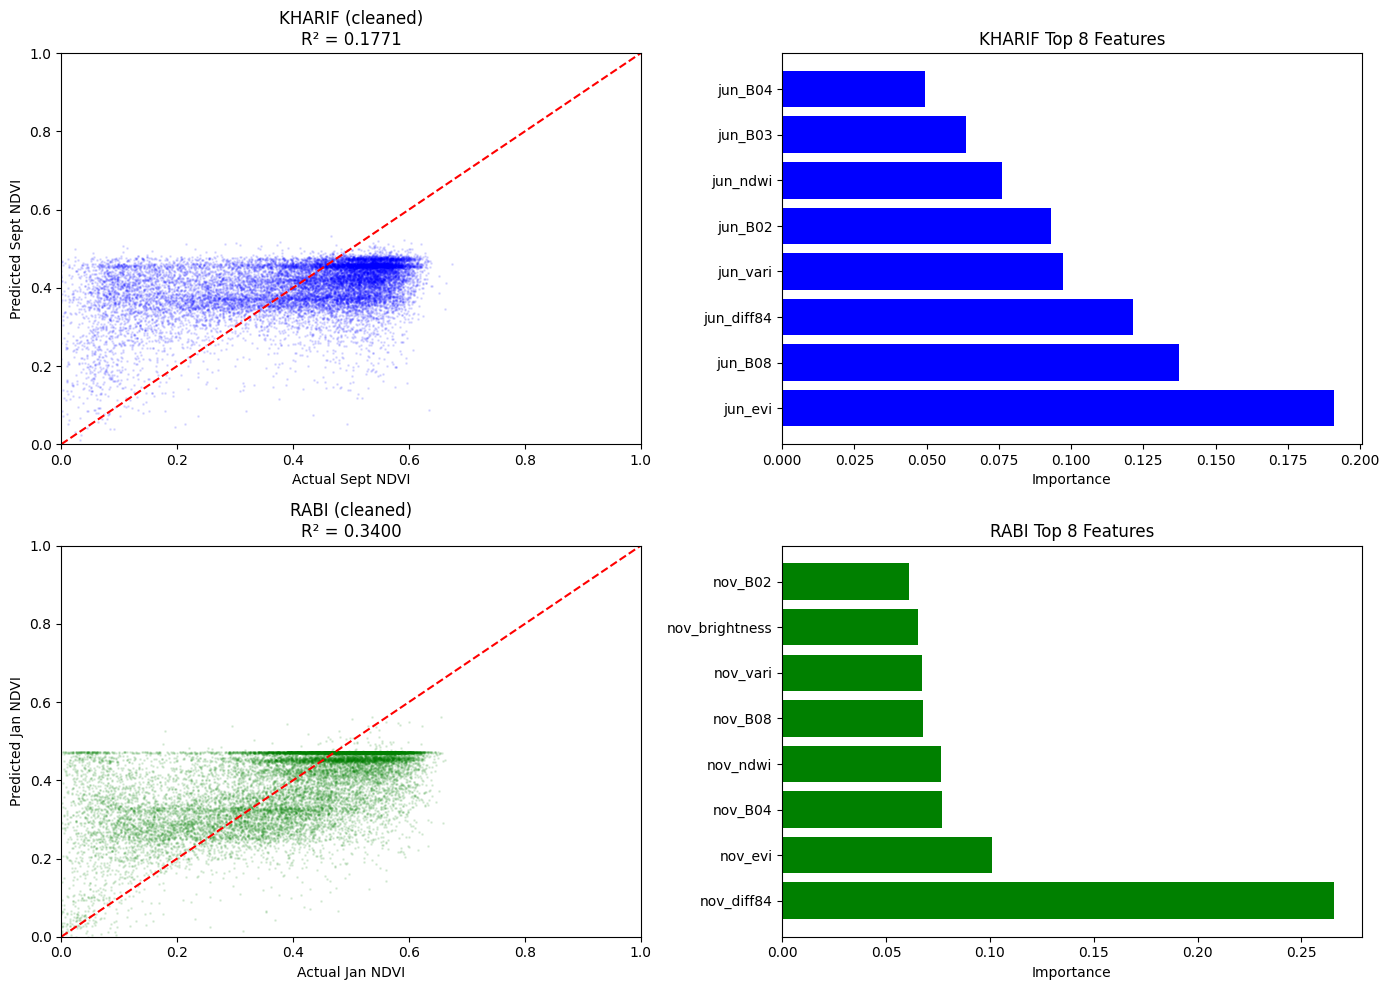

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Models downloaded to your computer!


In [ ]:


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import time

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/all_bands_indices_clean.csv')
print(f"Loaded {len(df):,} clean rows with {len(df.columns)} features")

print("\n" + "="*50)
print("KHARIF MODEL (cleaned data)")
print("="*50)

kharif_features = [col for col in df.columns if col.startswith('jun_')]
X_k = df[kharif_features]
y_k = df['sep_ndvi']

print(f"KHARIF features: {len(kharif_features)}")

Xk_train, Xk_test, yk_train, yk_test = train_test_split(X_k, y_k, test_size=0.2, random_state=42)

model_k = RandomForestRegressor(
    n_estimators=100,
    max_depth=12,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

print("Training KHARIF model...")
start = time.time()
model_k.fit(Xk_train, yk_train)
print(f"   ✓ Trained in {time.time()-start:.1f}s")

yk_pred = model_k.predict(Xk_test)
r2_k = r2_score(yk_test, yk_pred)
rmse_k = np.sqrt(mean_squared_error(yk_test, yk_pred))

print(f"\n KHARIF Results:")
print(f"   R²:  {r2_k:.4f}")
print(f"   RMSE: {rmse_k:.4f}")

print("\n" + "="*50)
print(" RABI MODEL (cleaned data)")
print("="*50)

rabi_features = [col for col in df.columns if col.startswith('nov_')]
X_r = df[rabi_features]
y_r = df['jan_ndvi']

print(f"RABI features: {len(rabi_features)}")

Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_r, y_r, test_size=0.2, random_state=42)

model_r = RandomForestRegressor(
    n_estimators=100,
    max_depth=12,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

print("Training RABI model...")
start = time.time()
model_r.fit(Xr_train, yr_train)
print(f"   ✓ Trained in {time.time()-start:.1f}s")

yr_pred = model_r.predict(Xr_test)
r2_r = r2_score(yr_test, yr_pred)
rmse_r = np.sqrt(mean_squared_error(yr_test, yr_pred))

print(f"\nRABI Results:")
print(f"   R²:  {r2_r:.4f}")
print(f"   RMSE: {rmse_r:.4f}")

print("\n" + "="*50)
print("FINAL RESULTS")
print("="*50)
print(f"{'Model':<20} {'R² Score':<15}")
print("-"*35)
print(f"{'KHARIF (June→Sept)':<20} {r2_k:<15.4f}")
print(f"{'RABI (Nov→Jan)':<20} {r2_r:<15.4f}")

print("\n" + "="*50)
print("top 10 FEATURES - KHARIF")
print("="*50)
k_imp = pd.DataFrame({
    'feature': kharif_features,
    'importance': model_k.feature_importances_
}).sort_values('importance', ascending=False).head(10)
print(k_imp.to_string(index=False))

print("\n" + "="*50)
print("TOP 10 FEATURES - RABI")
print("="*50)
r_imp = pd.DataFrame({
    'feature': rabi_features,
    'importance': model_r.feature_importances_
}).sort_values('importance', ascending=False).head(10)
print(r_imp.to_string(index=False))

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0,0].scatter(yk_test, yk_pred, alpha=0.1, s=1, c='blue')
axes[0,0].plot([0,1], [0,1], 'r--')
axes[0,0].set_xlabel('Actual Sept NDVI')
axes[0,0].set_ylabel('Predicted Sept NDVI')
axes[0,0].set_title(f'KHARIF (cleaned)\nR² = {r2_k:.4f}')
axes[0,0].set_xlim(0,1)
axes[0,0].set_ylim(0,1)

top_k = k_imp.head(8)
axes[0,1].barh(top_k['feature'], top_k['importance'], color='blue')
axes[0,1].set_xlabel('Importance')
axes[0,1].set_title('KHARIF Top 8 Features')

axes[1,0].scatter(yr_test, yr_pred, alpha=0.1, s=1, c='green')
axes[1,0].plot([0,1], [0,1], 'r--')
axes[1,0].set_xlabel('Actual Jan NDVI')
axes[1,0].set_ylabel('Predicted Jan NDVI')
axes[1,0].set_title(f'RABI (cleaned)\nR² = {r2_r:.4f}')
axes[1,0].set_xlim(0,1)
axes[1,0].set_ylim(0,1)

top_r = r_imp.head(8)
axes[1,1].barh(top_r['feature'], top_r['importance'], color='green')
axes[1,1].set_xlabel('Importance')
axes[1,1].set_title('RABI Top 8 Features')

plt.tight_layout()
plt.savefig('cleaned_indices_results.png', dpi=150)
plt.show()

import joblib
from google.colab import files

joblib.dump(model_k, 'kharif_model_enhanced.pkl')
joblib.dump(model_r, 'rabi_model_enhanced.pkl')

files.download('kharif_model_enhanced.pkl')
files.download('rabi_model_enhanced.pkl')


In [2]:

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/all_bands_indices_clean.csv')

# Kharif features
kharif_features = [col for col in df.columns if col.startswith('jun_')]
X = df[kharif_features]
y = df['sep_ndvi']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Try different algorithms
results = {}

# 1. Random Forest (your current)
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
results['Random Forest'] = r2_score(y_test, rf.predict(X_test))

# 2. XGBoost
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
xgb_model.fit(X_train, y_train)
results['XGBoost'] = r2_score(y_test, xgb_model.predict(X_test))

# 3. Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)
results['Gradient Boosting'] = r2_score(y_test, gb.predict(X_test))

# 4. Decision Tree
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(max_depth=10, random_state=42)
dt.fit(X_train, y_train)
results['Decision Tree'] = r2_score(y_test, dt.predict(X_test))

# 5. Linear Regression
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
results['Linear Regression'] = r2_score(y_test, lr.predict(X_test))

# Print results
print("\n" + "="*50)
print("ALGORITHM COMPARISON")
print("="*50)
for algo, r2 in sorted(results.items(), key=lambda x: x[1], reverse=True):
    print(f"{algo:20}: R² = {r2:.4f}")


📊 ALGORITHM COMPARISON
XGBoost             : R² = 0.1776
Gradient Boosting   : R² = 0.1601
Random Forest       : R² = 0.1371
Decision Tree       : R² = 0.1154
Linear Regression   : R² = 0.0496
